Loading data...
Found 10 CSV files
max_displacement_bampf: 10 files, 14110 total rows

Calculating statistics (raw + EMA)...
max_displacement_bampf: approx 10 seeds (episodes: 1653)

Creating plots...
Creating raw individual plots...


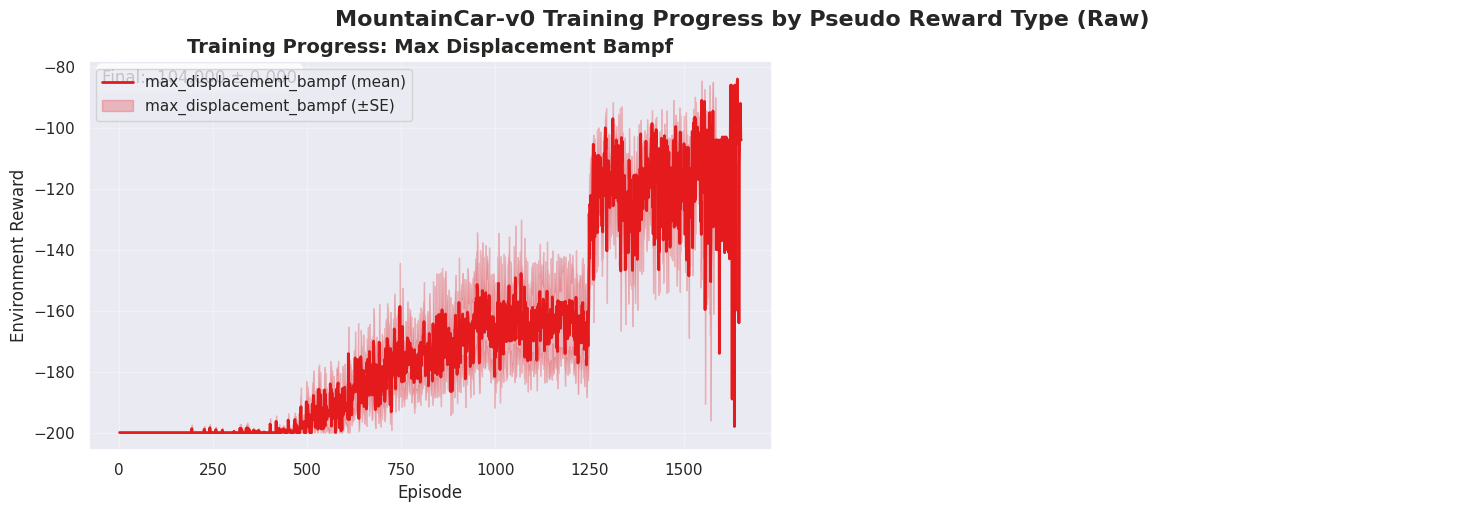

Creating raw comparison plot...


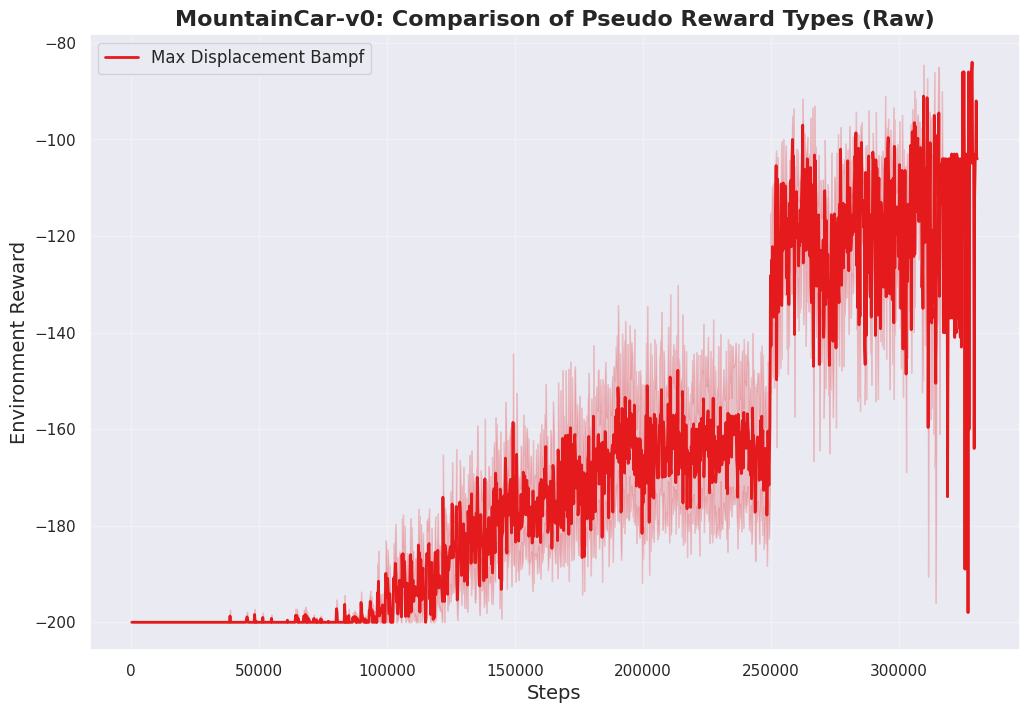

Creating EMA individual plots...


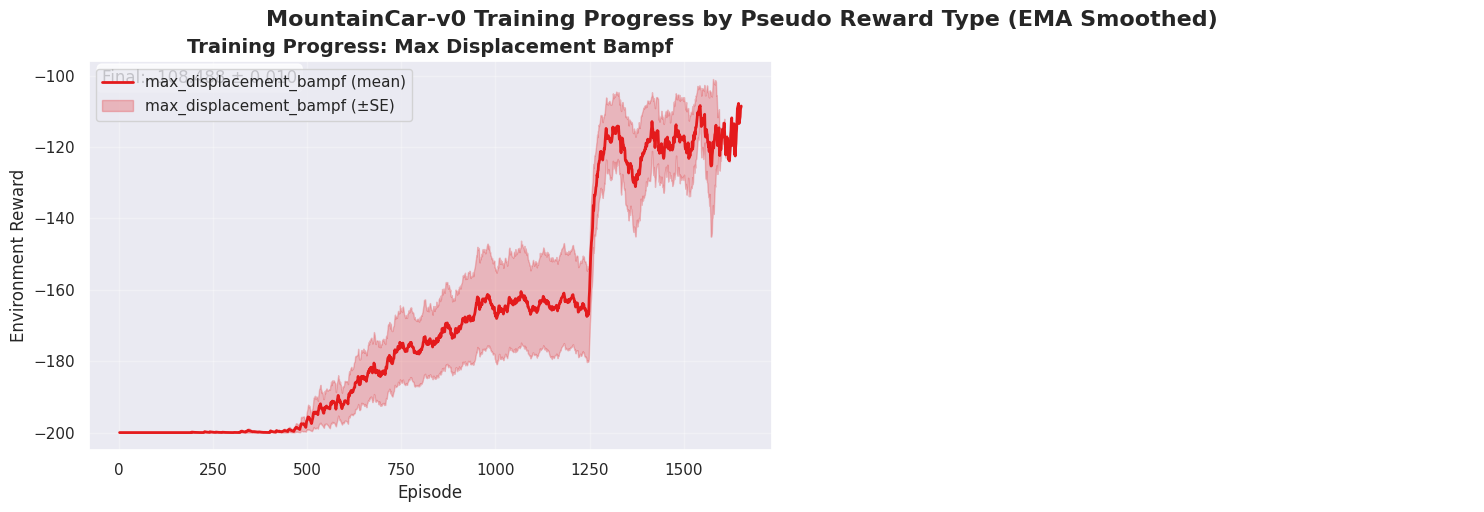

Creating EMA comparison plot...


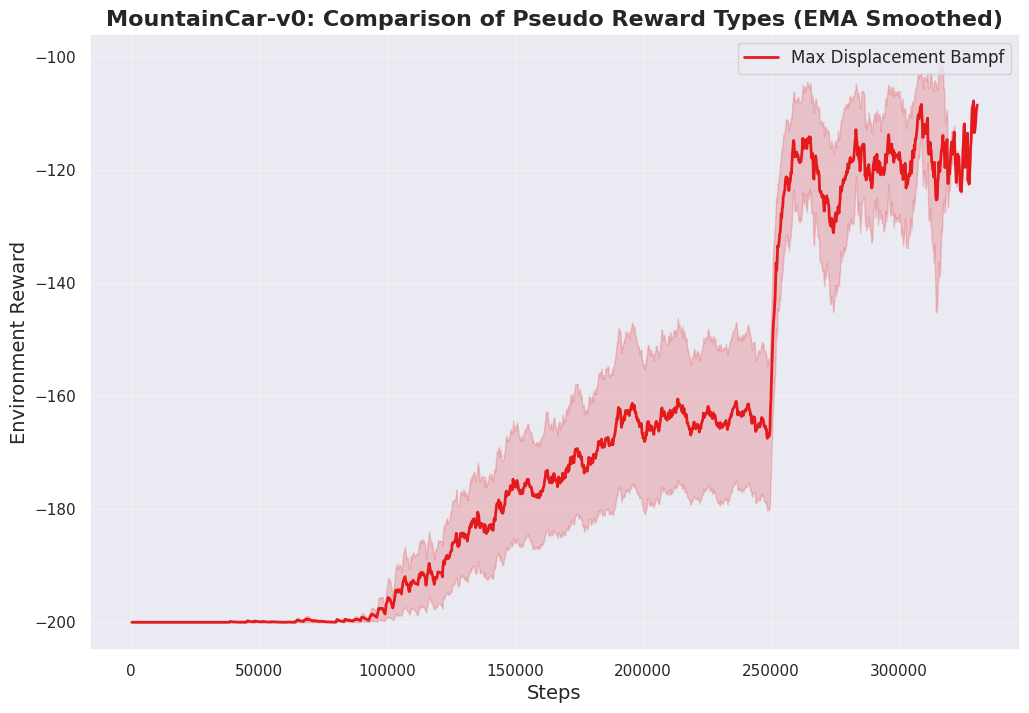


Summary Statistics (Raw Data):
Max Displacement Bampf:
  Final reward: -104.0000 ± 0.0000
  Max reward: -84.0000
  Episodes: 1653


Summary Statistics (EMA Smoothed):
Max Displacement Bampf:
  Final reward (EMA): -108.4876 ± 0.0104
  Max reward (EMA): -107.7603
  Episodes: 1653



In [3]:
import os
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_process_data(data_dir):
    """
    Load all CSV files from data_dir and organize them by pseudo reward type.
    Expects filenames containing patterns like: _<pseudo_reward>_episodes.csv and _seed<N>_...
    Returns a dict: {reward_type: combined_dataframe}
    """
    pseudo_reward_types = ['displacement', 'displacement_pbs', 'max_displacement_bampf', 'none']
    data_by_type = {reward_type: [] for reward_type in pseudo_reward_types}

    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        filename = os.path.basename(file_path)

        # Determine reward type from filename
        reward_type = None
        for ptype in pseudo_reward_types:
            if f"_{ptype}_episodes.csv" in filename:
                reward_type = ptype
                break

        if reward_type is None:
            print(f"Warning: Could not determine reward type for {filename}")
            continue

        # Load CSV
        try:
            df = pd.read_csv(file_path)
            # Extract seed (best-effort)
            try:
                seed_part = filename.split('_seed')[1].split('_')[0].split('.')[0]
                df['seed'] = int(seed_part)
            except Exception:
                df['seed'] = np.nan

            df['pseudo_reward_type'] = reward_type
            data_by_type[reward_type].append(df)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    combined_data = {}
    for reward_type in pseudo_reward_types:
        if data_by_type[reward_type]:
            combined_data[reward_type] = pd.concat(data_by_type[reward_type], ignore_index=True)
            print(f"{reward_type}: {len(data_by_type[reward_type])} files, {len(combined_data[reward_type])} total rows")
        else:
            print(f"Warning: No data found for {reward_type}")

    return combined_data


def calculate_statistics(data_dict, ema_alpha=None):
    """
    For each reward type, compute per-episode mean, std, count and standard error across seeds.
    If ema_alpha is provided, also return EMA-smoothed versions (applied to 'mean' and 'se').
    Returns: (stats_dict, ema_stats_dict)
    """
    stats_dict = {}
    ema_stats_dict = {}

    for reward_type, df in data_dict.items():
        if df is None or df.empty:
            print(f"Skipping {reward_type} - no data")
            continue

        if 'episode_id' not in df.columns or 'env_reward' not in df.columns:
            print(f"Skipping {reward_type} - missing required columns 'episode_id' or 'env_reward'")
            continue

        # Group by episode_id and seed -> mean env_reward per (episode, seed)
        grouped = df.groupby(['episode_id', 'seed'], dropna=False)['env_reward'].mean().reset_index()
        grouped = grouped.sort_values('episode_id')

        # Aggregate across seeds
        episode_stats = grouped.groupby('episode_id')['env_reward'].agg(['mean', 'std', 'count']).reset_index()
        episode_stats = episode_stats.rename(columns={'count': 'n'})
        episode_stats['se'] = episode_stats['std'] / np.sqrt(episode_stats['n'])
        episode_stats['se'] = episode_stats['se'].fillna(0)
        episode_stats['std'] = episode_stats['std'].fillna(0)

        stats_dict[reward_type] = episode_stats

        num_seeds = int(grouped['seed'].nunique()) if not grouped['seed'].isna().all() else 0
        print(f"{reward_type}: approx {num_seeds} seeds (episodes: {len(episode_stats)})")

        # EMA smoothing if requested
        if ema_alpha is not None:
            ema_df = episode_stats.copy().sort_values('episode_id')
            ema_df['mean'] = ema_df['mean'].ewm(alpha=ema_alpha, adjust=False).mean()
            ema_df['se'] = ema_df['se'].ewm(alpha=ema_alpha, adjust=False).mean()
            ema_stats_dict[reward_type] = ema_df

    return stats_dict, ema_stats_dict


def create_plots(stats_dict, title_suffix=""):
    """
    Create a grid of subplots (2 columns) — one subplot per reward type — showing mean ± SE.
    Uses a 4-color distinct palette to ensure each line is visually distinct.
    Returns: matplotlib.figure.Figure
    """
    if not stats_dict:
        raise ValueError("No data in stats_dict to plot.")

    plt.style.use('default')
    sns.set_theme()  # keep sns styling consistent

    n = len(stats_dict)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.ravel(axes)

    # Distinct, colorblind-friendly palette (4 colors)
    base_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # red, blue, green, purple
    if n <= len(base_colors):
        colors_list = base_colors[:n]
    else:
        colors_list = sns.color_palette(n_colors=n)

    for idx, (reward_type, stats_df) in enumerate(stats_dict.items()):
        ax = axes[idx]
        stats_df = stats_df.sort_values('episode_id')
        x = stats_df['episode_id'].to_numpy()
        y_mean = stats_df['mean'].to_numpy()
        y_se = stats_df['se'].to_numpy()

        color = colors_list[idx]
        ax.plot(x, y_mean, color=color, linewidth=2, label=f'{reward_type} (mean)')
        ax.fill_between(x, y_mean - y_se, y_mean + y_se, color=color, alpha=0.25, label=f'{reward_type} (±SE)')

        ax.set_title(f'Training Progress: {reward_type.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Environment Reward', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Summary text in top-left
        if len(y_mean) > 0:
            final_mean = y_mean[-1]
            final_se = y_se[-1]
        else:
            final_mean = 0.0
            final_se = 0.0
        ax.text(0.02, 0.98, f'Final: {final_mean:.3f} ± {final_se:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Turn off unused axes if any
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle('MountainCar-v0 Training Progress by Pseudo Reward Type' + title_suffix,
                 fontsize=16, fontweight='bold', y=1.02)
    return fig


def create_comparison_plot(stats_dict, title_suffix=""):
    """
    Create a single comparison plot with all reward types (mean ± SE) using the same distinct palette.
    Returns: matplotlib.figure.Figure
    """
    if not stats_dict:
        raise ValueError("No data in stats_dict to plot.")

    plt.figure(figsize=(12, 8))

    base_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # red, blue, green, purple
    n = len(stats_dict)
    if n <= len(base_colors):
        colors_list = base_colors[:n]
    else:
        colors_list = sns.color_palette(n_colors=n)

    for idx, (reward_type, stats_df) in enumerate(stats_dict.items()):
        stats_df = stats_df.sort_values('episode_id')
        x = stats_df['episode_id'].to_numpy()*200
        y_mean = stats_df['mean'].to_numpy()
        y_se = stats_df['se'].to_numpy()
        color = colors_list[idx]
        plt.plot(x, y_mean, linewidth=2, label=f'{reward_type.replace("_", " ").title()}', color=color)
        plt.fill_between(x, y_mean - y_se, y_mean + y_se, alpha=0.2, color=color)

    plt.title('MountainCar-v0: Comparison of Pseudo Reward Types' + title_suffix, fontsize=16, fontweight='bold')
    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Environment Reward', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    return plt.gcf()


def main():
    # >>> UPDATE this path to where your CSVs live <<<
    # Example: r"D:\BAMPD\logs\MountainCar-v0"
    data_dir = r"/teamspace/studios/this_studio/gymnax-blines/episode_logs"

    print("Loading data...")
    data_dict = load_and_process_data(data_dir)

    if not data_dict:
        print("No data loaded. Please check the directory path and file structure.")
        return

    print("\nCalculating statistics (raw + EMA)...")
    stats_dict, ema_stats_dict = calculate_statistics(data_dict, ema_alpha=0.1)

    print("\nCreating plots...")

    # 1. Raw individual plots
    print("Creating raw individual plots...")
    fig1 = create_plots(stats_dict, title_suffix=" (Raw)")
    plt.show()

    # 2. Raw comparison
    print("Creating raw comparison plot...")
    fig2 = create_comparison_plot(stats_dict, title_suffix=" (Raw)")
    plt.show()

    # 3. EMA individual plots (if present)
    if ema_stats_dict:
        print("Creating EMA individual plots...")
        fig3 = create_plots(ema_stats_dict, title_suffix=" (EMA Smoothed)")
        plt.show()

        # 4. EMA comparison
        print("Creating EMA comparison plot...")
        fig4 = create_comparison_plot(ema_stats_dict, title_suffix=" (EMA Smoothed)")
        plt.show()
    else:
        print("No EMA stats available (ema_alpha was None or data missing).")

    # Print summary stats
    print("\nSummary Statistics (Raw Data):")
    print("=" * 60)
    for reward_type, stats_df in stats_dict.items():
        if stats_df is None or stats_df.empty:
            continue
        final_mean = stats_df['mean'].iloc[-1]
        final_std = stats_df['std'].iloc[-1]
        max_mean = stats_df['mean'].max()
        print(f"{reward_type.replace('_', ' ').title()}:")
        print(f"  Final reward: {final_mean:.4f} ± {final_std:.4f}")
        print(f"  Max reward: {max_mean:.4f}")
        print(f"  Episodes: {len(stats_df)}")
        print()

    if ema_stats_dict:
        print("\nSummary Statistics (EMA Smoothed):")
        print("=" * 60)
        for reward_type, stats_df in ema_stats_dict.items():
            if stats_df is None or stats_df.empty:
                continue
            final_mean = stats_df['mean'].iloc[-1]
            final_se = stats_df['se'].iloc[-1]
            max_mean = stats_df['mean'].max()
            print(f"{reward_type.replace('_', ' ').title()}:")
            print(f"  Final reward (EMA): {final_mean:.4f} ± {final_se:.4f}")
            print(f"  Max reward (EMA): {max_mean:.4f}")
            print(f"  Episodes: {len(stats_df)}")
            print()


if __name__ == "__main__":
    main()


Loading data...
Found 10 CSV files
max_displacement_bampf: 10 files, 14168 total rows

Calculating statistics (raw + EMA)...
max_displacement_bampf: approx 10 seeds (episodes: 1674)

Creating plots...
Creating raw individual plots...


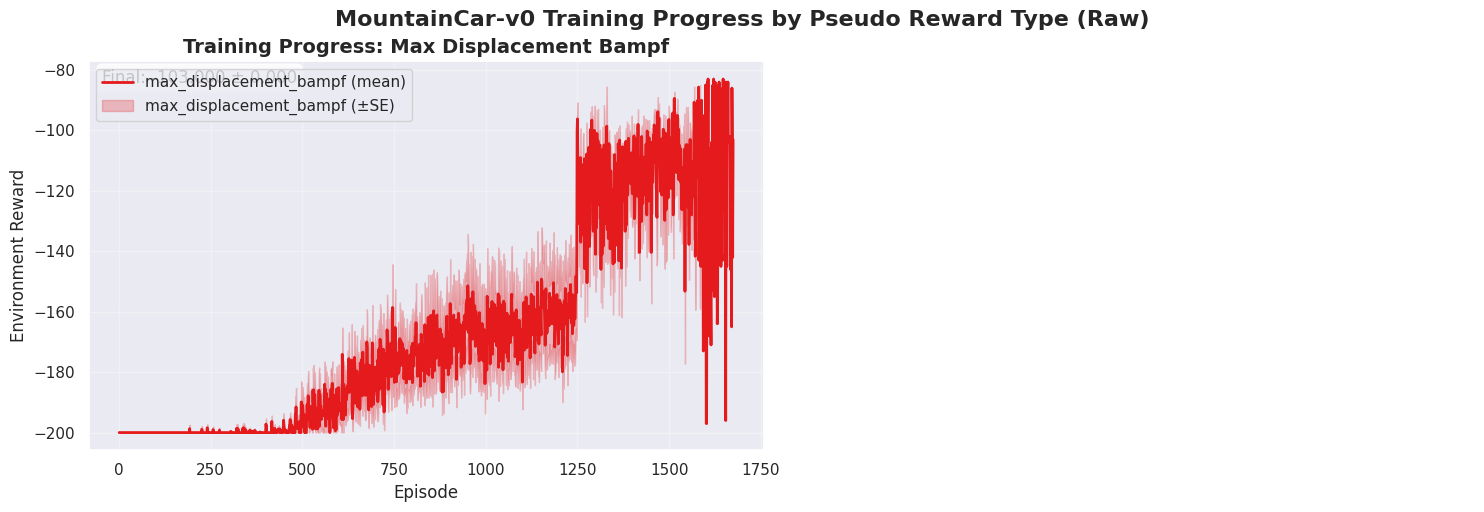

Creating raw comparison plot...


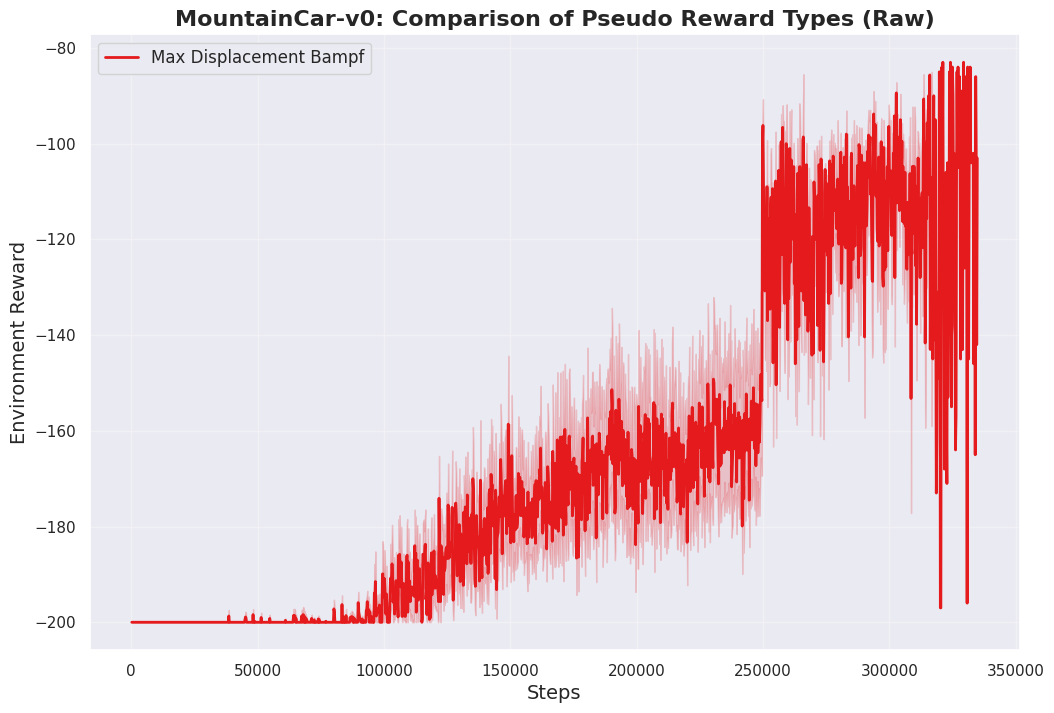

Creating EMA individual plots...


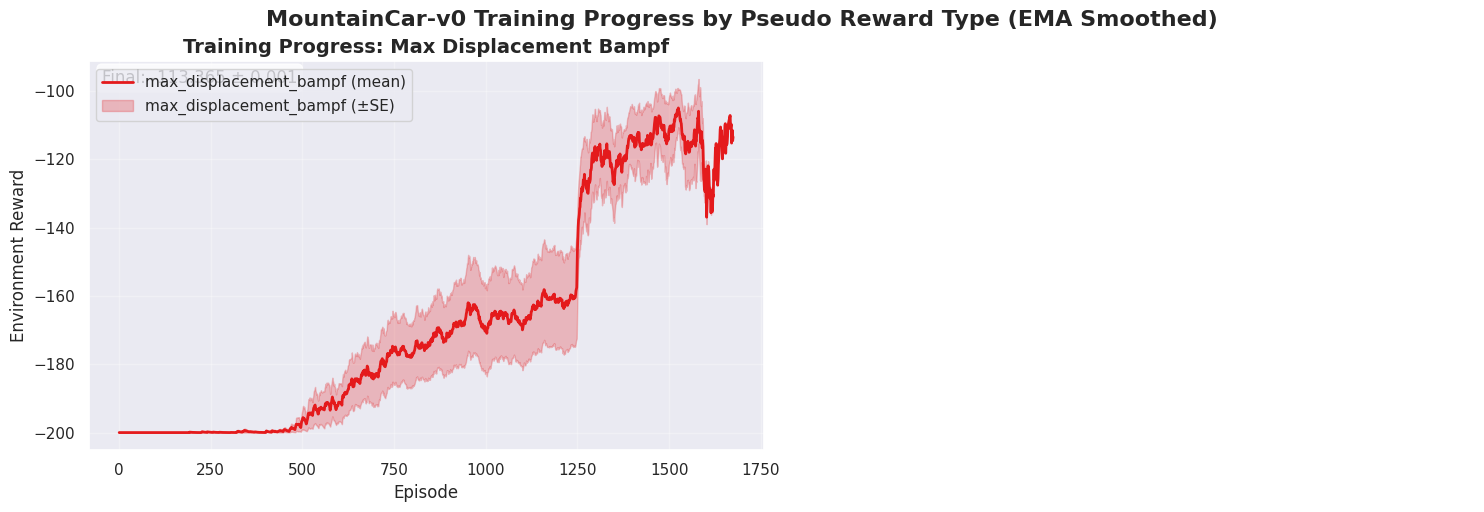

Creating EMA comparison plot...


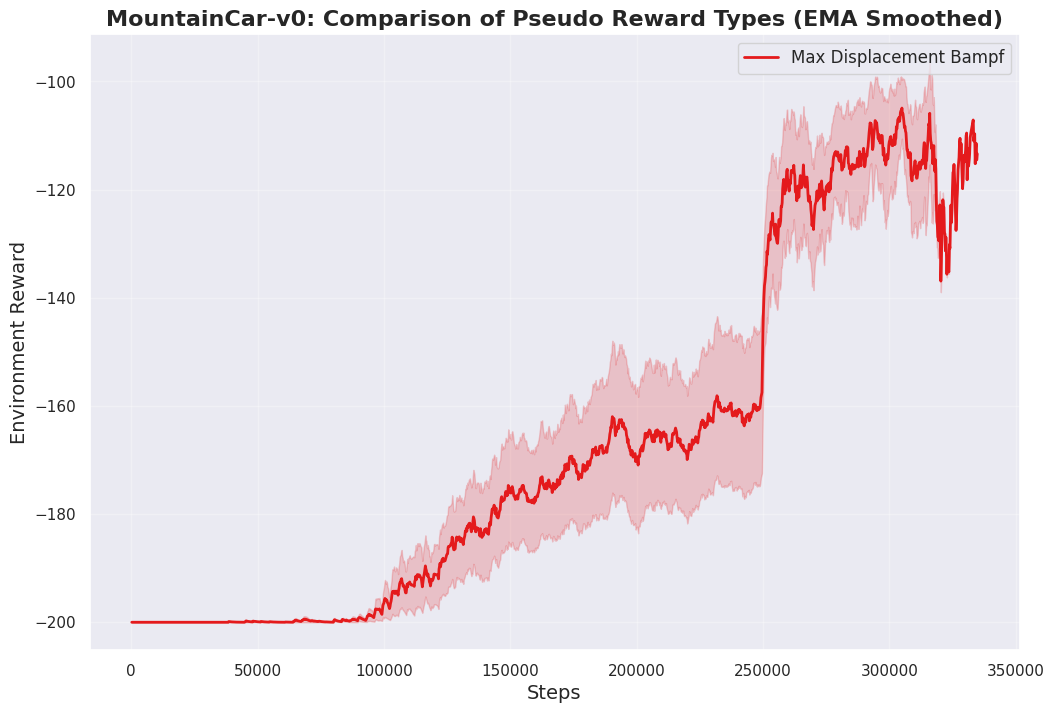


Summary Statistics (Raw Data):
Max Displacement Bampf:
  Final reward: -103.0000 ± 0.0000
  Max reward: -83.0000
  Episodes: 1674


Summary Statistics (EMA Smoothed):
Max Displacement Bampf:
  Final reward (EMA): -113.3648 ± 0.0010
  Max reward (EMA): -104.9235
  Episodes: 1674



In [1]:
import os
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_process_data(data_dir):
    """
    Load all CSV files from data_dir and organize them by pseudo reward type.
    Expects filenames containing patterns like: _<pseudo_reward>_episodes.csv and _seed<N>_...
    Returns a dict: {reward_type: combined_dataframe}
    """
    pseudo_reward_types = ['displacement', 'displacement_pbs', 'max_displacement_bampf', 'none']
    data_by_type = {reward_type: [] for reward_type in pseudo_reward_types}

    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        filename = os.path.basename(file_path)

        # Determine reward type from filename
        reward_type = None
        for ptype in pseudo_reward_types:
            if f"_{ptype}_episodes.csv" in filename:
                reward_type = ptype
                break

        if reward_type is None:
            print(f"Warning: Could not determine reward type for {filename}")
            continue

        # Load CSV
        try:
            df = pd.read_csv(file_path)
            # Extract seed (best-effort)
            try:
                seed_part = filename.split('_seed')[1].split('_')[0].split('.')[0]
                df['seed'] = int(seed_part)
            except Exception:
                df['seed'] = np.nan

            df['pseudo_reward_type'] = reward_type
            data_by_type[reward_type].append(df)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    combined_data = {}
    for reward_type in pseudo_reward_types:
        if data_by_type[reward_type]:
            combined_data[reward_type] = pd.concat(data_by_type[reward_type], ignore_index=True)
            print(f"{reward_type}: {len(data_by_type[reward_type])} files, {len(combined_data[reward_type])} total rows")
        else:
            print(f"Warning: No data found for {reward_type}")

    return combined_data


def calculate_statistics(data_dict, ema_alpha=None):
    """
    For each reward type, compute per-episode mean, std, count and standard error across seeds.
    If ema_alpha is provided, also return EMA-smoothed versions (applied to 'mean' and 'se').
    Returns: (stats_dict, ema_stats_dict)
    """
    stats_dict = {}
    ema_stats_dict = {}

    for reward_type, df in data_dict.items():
        if df is None or df.empty:
            print(f"Skipping {reward_type} - no data")
            continue

        if 'episode_id' not in df.columns or 'env_reward' not in df.columns:
            print(f"Skipping {reward_type} - missing required columns 'episode_id' or 'env_reward'")
            continue

        # Group by episode_id and seed -> mean env_reward per (episode, seed)
        grouped = df.groupby(['episode_id', 'seed'], dropna=False)['env_reward'].mean().reset_index()
        grouped = grouped.sort_values('episode_id')

        # Aggregate across seeds
        episode_stats = grouped.groupby('episode_id')['env_reward'].agg(['mean', 'std', 'count']).reset_index()
        episode_stats = episode_stats.rename(columns={'count': 'n'})
        episode_stats['se'] = episode_stats['std'] / np.sqrt(episode_stats['n'])
        episode_stats['se'] = episode_stats['se'].fillna(0)
        episode_stats['std'] = episode_stats['std'].fillna(0)

        stats_dict[reward_type] = episode_stats

        num_seeds = int(grouped['seed'].nunique()) if not grouped['seed'].isna().all() else 0
        print(f"{reward_type}: approx {num_seeds} seeds (episodes: {len(episode_stats)})")

        # EMA smoothing if requested
        if ema_alpha is not None:
            ema_df = episode_stats.copy().sort_values('episode_id')
            ema_df['mean'] = ema_df['mean'].ewm(alpha=ema_alpha, adjust=False).mean()
            ema_df['se'] = ema_df['se'].ewm(alpha=ema_alpha, adjust=False).mean()
            ema_stats_dict[reward_type] = ema_df

    return stats_dict, ema_stats_dict


def create_plots(stats_dict, title_suffix=""):
    """
    Create a grid of subplots (2 columns) — one subplot per reward type — showing mean ± SE.
    Uses a 4-color distinct palette to ensure each line is visually distinct.
    Returns: matplotlib.figure.Figure
    """
    if not stats_dict:
        raise ValueError("No data in stats_dict to plot.")

    plt.style.use('default')
    sns.set_theme()  # keep sns styling consistent

    n = len(stats_dict)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.ravel(axes)

    # Distinct, colorblind-friendly palette (4 colors)
    base_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # red, blue, green, purple
    if n <= len(base_colors):
        colors_list = base_colors[:n]
    else:
        colors_list = sns.color_palette(n_colors=n)

    for idx, (reward_type, stats_df) in enumerate(stats_dict.items()):
        ax = axes[idx]
        stats_df = stats_df.sort_values('episode_id')
        x = stats_df['episode_id'].to_numpy()
        y_mean = stats_df['mean'].to_numpy()
        y_se = stats_df['se'].to_numpy()

        color = colors_list[idx]
        ax.plot(x, y_mean, color=color, linewidth=2, label=f'{reward_type} (mean)')
        ax.fill_between(x, y_mean - y_se, y_mean + y_se, color=color, alpha=0.25, label=f'{reward_type} (±SE)')

        ax.set_title(f'Training Progress: {reward_type.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Environment Reward', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Summary text in top-left
        if len(y_mean) > 0:
            final_mean = y_mean[-1]
            final_se = y_se[-1]
        else:
            final_mean = 0.0
            final_se = 0.0
        ax.text(0.02, 0.98, f'Final: {final_mean:.3f} ± {final_se:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Turn off unused axes if any
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle('MountainCar-v0 Training Progress by Pseudo Reward Type' + title_suffix,
                 fontsize=16, fontweight='bold', y=1.02)
    return fig


def create_comparison_plot(stats_dict, title_suffix=""):
    """
    Create a single comparison plot with all reward types (mean ± SE) using the same distinct palette.
    Returns: matplotlib.figure.Figure
    """
    if not stats_dict:
        raise ValueError("No data in stats_dict to plot.")

    plt.figure(figsize=(12, 8))

    base_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # red, blue, green, purple
    n = len(stats_dict)
    if n <= len(base_colors):
        colors_list = base_colors[:n]
    else:
        colors_list = sns.color_palette(n_colors=n)

    for idx, (reward_type, stats_df) in enumerate(stats_dict.items()):
        stats_df = stats_df.sort_values('episode_id')
        x = stats_df['episode_id'].to_numpy()*200
        y_mean = stats_df['mean'].to_numpy()
        y_se = stats_df['se'].to_numpy()
        color = colors_list[idx]
        plt.plot(x, y_mean, linewidth=2, label=f'{reward_type.replace("_", " ").title()}', color=color)
        plt.fill_between(x, y_mean - y_se, y_mean + y_se, alpha=0.2, color=color)

    plt.title('MountainCar-v0: Comparison of Pseudo Reward Types' + title_suffix, fontsize=16, fontweight='bold')
    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Environment Reward', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    return plt.gcf()


def main():
    # >>> UPDATE this path to where your CSVs live <<<
    # Example: r"D:\BAMPD\logs\MountainCar-v0"
    data_dir = r"/teamspace/studios/this_studio/gymnax-blines/episode_logs"

    print("Loading data...")
    data_dict = load_and_process_data(data_dir)

    if not data_dict:
        print("No data loaded. Please check the directory path and file structure.")
        return

    print("\nCalculating statistics (raw + EMA)...")
    stats_dict, ema_stats_dict = calculate_statistics(data_dict, ema_alpha=0.1)

    print("\nCreating plots...")

    # 1. Raw individual plots
    print("Creating raw individual plots...")
    fig1 = create_plots(stats_dict, title_suffix=" (Raw)")
    plt.show()

    # 2. Raw comparison
    print("Creating raw comparison plot...")
    fig2 = create_comparison_plot(stats_dict, title_suffix=" (Raw)")
    plt.show()

    # 3. EMA individual plots (if present)
    if ema_stats_dict:
        print("Creating EMA individual plots...")
        fig3 = create_plots(ema_stats_dict, title_suffix=" (EMA Smoothed)")
        plt.show()

        # 4. EMA comparison
        print("Creating EMA comparison plot...")
        fig4 = create_comparison_plot(ema_stats_dict, title_suffix=" (EMA Smoothed)")
        plt.show()
    else:
        print("No EMA stats available (ema_alpha was None or data missing).")

    # Print summary stats
    print("\nSummary Statistics (Raw Data):")
    print("=" * 60)
    for reward_type, stats_df in stats_dict.items():
        if stats_df is None or stats_df.empty:
            continue
        final_mean = stats_df['mean'].iloc[-1]
        final_std = stats_df['std'].iloc[-1]
        max_mean = stats_df['mean'].max()
        print(f"{reward_type.replace('_', ' ').title()}:")
        print(f"  Final reward: {final_mean:.4f} ± {final_std:.4f}")
        print(f"  Max reward: {max_mean:.4f}")
        print(f"  Episodes: {len(stats_df)}")
        print()

    if ema_stats_dict:
        print("\nSummary Statistics (EMA Smoothed):")
        print("=" * 60)
        for reward_type, stats_df in ema_stats_dict.items():
            if stats_df is None or stats_df.empty:
                continue
            final_mean = stats_df['mean'].iloc[-1]
            final_se = stats_df['se'].iloc[-1]
            max_mean = stats_df['mean'].max()
            print(f"{reward_type.replace('_', ' ').title()}:")
            print(f"  Final reward (EMA): {final_mean:.4f} ± {final_se:.4f}")
            print(f"  Max reward (EMA): {max_mean:.4f}")
            print(f"  Episodes: {len(stats_df)}")
            print()


if __name__ == "__main__":
    main()
